In [ ]:
import sys, os
sys.path.append('..')
os.chdir('..')

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from emonet.models import EmoNet

In [ ]:
def to_np(x: torch.Tensor) -> np.ndarray:
    return x.permute(1, 2, 0).detach().numpy()

In [ ]:
# load params
state = torch.load("pretrained/emonet_8.pth", map_location="cpu")
state = { k.replace("module.", ""): v for k, v in state.items() }

model = EmoNet(n_expression=8)
model.load_state_dict(state)
modules = list(model._modules.keys())
len(modules)

In [ ]:
# TEST: print modules
# model._modules['conv1']
for idx, name in enumerate(modules):
    tensor = model._modules[name]
    print(' {:>3} :  {:<20} {:<50} {}'.format(idx+1, name, str(type(tensor)), isinstance(tensor, nn.Conv2d)))
    # print(tensor._parameters)
    # break

In [ ]:
# load image as tensor
img_path = Path("media/images/example.png")
bgr = cv2.imread(str(img_path))
bgr = cv2.resize(bgr, (256, 256))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
x = (torch.from_numpy(rgb).permute(2, 0, 1).float() / 255.0).unsqueeze(0)
x.shape

In [ ]:
# show initial image
plt.imshow(to_np(x[0]))
plt.show()

In [ ]:
# add forward hooks to modules
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for idx, name in enumerate(modules):
    print("adding forward hook to:", name)
    model._modules[name].register_forward_hook(get_activation(name))

adding forward hook to: conv1
adding forward hook to: bn1
adding forward hook to: conv2
adding forward hook to: conv3
adding forward hook to: conv4
adding forward hook to: m0
adding forward hook to: top_m_0
adding forward hook to: conv_last0
adding forward hook to: bn_end0
adding forward hook to: l0
adding forward hook to: bl0
adding forward hook to: al0
adding forward hook to: m1
adding forward hook to: top_m_1
adding forward hook to: conv_last1
adding forward hook to: bn_end1
adding forward hook to: l1
adding forward hook to: conv1x1_input_emo_2
adding forward hook to: emo_net_2
adding forward hook to: avg_pool_2
adding forward hook to: emo_fc_2


In [ ]:
# evaluate whole model
model.eval()
with torch.no_grad():
    out = model(x)

In [54]:
def get_rows_and_cols(i: int) -> tuple[int, int]:
    return 4, 4

In [37]:
def get_module_class_name(module) -> str:
    cls_str = str(type(module))
    return cls_str.split('.')[-1].split("'")[0]

name: bl0
type: Conv2d
shape: (256, 64, 64)
dim: 3


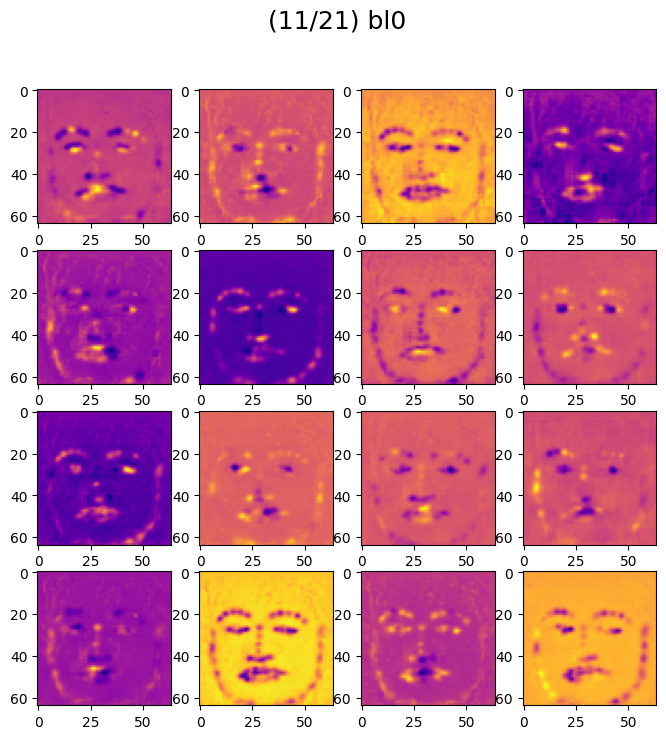

In [73]:
# VISUALIZE: tensor after given layer
idx = 10#len(modules)-1-5
name = modules[idx]
module = model._modules[name]
print('name:', name)
cls = get_module_class_name(module)
print('type:', cls)
out = activations[name]

limit = None
arr = out.detach().numpy()[0]
if limit:
    arr = arr[:limit,:,:]
shape = arr.shape
print('shape:', shape)
print('dim:', len(shape))


if len(shape) == 1: # final layer
    plt.bar(range(len(arr)), arr)
    plt.show()

elif shape[1] == 1 and shape[2] == 1: # img size 1x1
    data = arr[:,0,0]
    x_ticks = np.arange(len(data))
    plt.bar(x_ticks, data)
    plt.show()

else:
    nrows, ncols = get_rows_and_cols(x.shape[0])

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*2, ncols*2))
    title = f"({idx+1}/{len(modules)}) {name}"
    plt.suptitle(title, fontsize=18)
    for idx, axis in enumerate(ax.flatten()):
        axis.imshow(arr[idx], cmap='plasma')
    plt.show()